# Robust Principal Component Analysis
This notebook contains an implementation of Robust PCA with an application to moving object detection in surveillance video. The motivation and details can be found in this fantastic original paper: https://dl.acm.org/doi/10.1145/1970392.1970395 (Robust principal component analysis?)

### Robust PCA fuction

In [1]:
import numpy as np 
from __future__ import division
from scipy.sparse.linalg import svds


def robustPCA(X, delta=1e-7, mu=None, maxiter=500):

    '''
    The function returns a PCA like part stored in 'L' with only a few singular values 
    that are non zero and a sparse sequence 'S' in which the images are black except w very 
    limited number of pixels
    '''
    n_1, n_2 = np.shape(X)
    # Initialize the tuning parameters.
    lam = 1/max(n_1,n_2)
    if mu is None:
        mu = n_1*n_2 / (4* np.sum(np.abs(X)))
        
    # Convergence criterion.
    norm = np.sum(X ** 2)

    # Iterate.
    i = 0
    S = np.zeros((n_1, n_2))
    Y = np.zeros((n_1, n_2))
    while i < max(maxiter, 1):           
        # Step 1. Compute and truncate the SVD
        U, sigma, Vh = np.linalg.svd(X - S - Y/mu)
        sigma = np.maximum(sigma-mu, np.zeros(len(sigma))) # truncate the singular value vectors
        Sigma = np.zeros((n_1,n_2)) # the singular matrix
        for i in range(len(sigma)): # reconstruct the singular matrix from the singular vector
            Sigma[i,i] = sigma[i]
        L = U @ Sigma @ Vh
        # Step 2. Truncate the entries of X - L + mu^(-1)Y
        temp = X-L+Y/mu
        S = np.multiply(np.sign(temp), np.maximum(np.abs(temp)-lam*mu, np.zeros(np.shape(temp))))

        # Step 3. Update the matrix Y
        Y = Y + mu*(X-L-S)
        

        # Convergence criterion
        err = np.sqrt(np.sum((X-L-S)**2) / norm)
        if err < delta:
            break
        i += 1

        if i >= maxiter:
            break
        
    return L, S

### Here is a sample video:

In [2]:
# Open the video and get relevant information
import cv2

vid_capture = cv2.VideoCapture("escalator.avi")
if (vid_capture.isOpened() == False):
    print("Error opening the video file")
else:
    width = int(vid_capture.get(3))
    height =int(vid_capture.get(4))
    img_shape = (height, width)
    fps = int(vid_capture.get(5))     
    frame_count = int(vid_capture.get(7))
    print("Frame Rate: ",fps,"frames per second") 
    print("Frame count: ", frame_count)
    print("Height, Width: ", height, width)

Frame Rate:  15 frames per second
Frame count:  200
Height, Width:  130 160


In [3]:
# Read frames from the video
frames = []
success = True
count = 0
while success:
    success, frame = vid_capture.read()
    if success == True:
        frames.append(frame)
        # print(count)
        count += 1

In [4]:
# Load the frames into a data matrix, each column being a frame of the grayscale image
frame_count = len(frames)
X = np.empty((height*width, frame_count))
for i in range(frame_count):
    if frames[i] is not None:
        gray_img = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY) # convert to grayscale
        X[:,i] = gray_img.flatten() # add to the data matrix

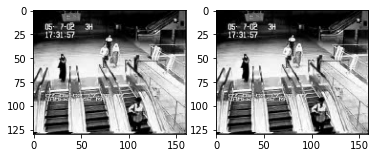

In [5]:
# display one image
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(frames[0])
ax2.imshow(X[:,0].reshape((130,160)), cmap='gray')

In [6]:
# Compute the robust PCA
L, S = robustPCA(X)

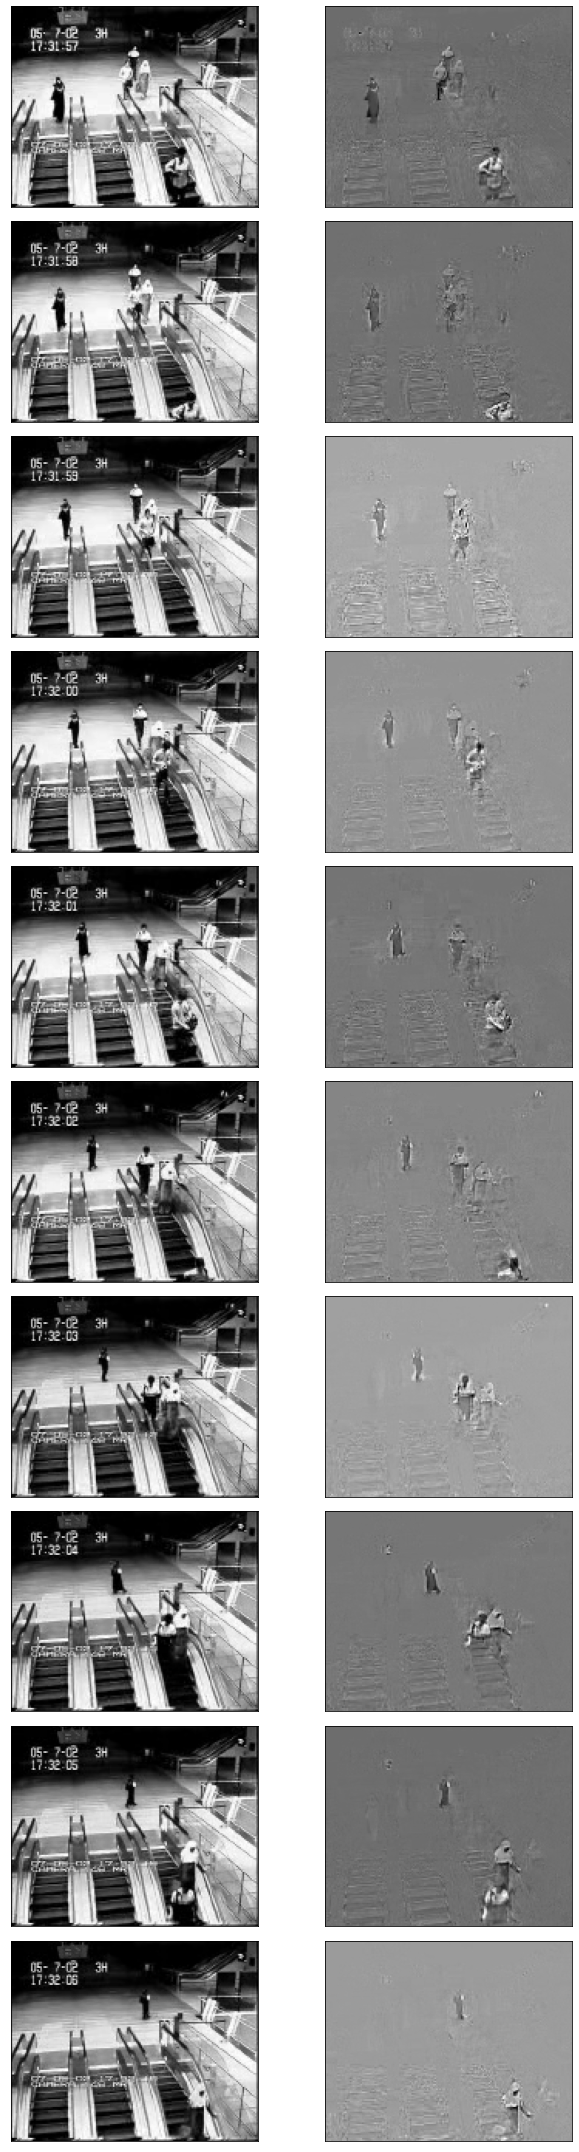

In [7]:
# plot the image decomposition every 10 frame
fig, ax = plt.subplots(nrows=10, ncols=2, figsize = (10,30))
for row in range(10):
    ax[row,0].imshow(L[:,10*row].reshape(img_shape), cmap='gray')
    ax[row,1].imshow(S[:,10*row].reshape(img_shape), cmap='gray')
    ax[row,0].set_xticks([])
    ax[row,0].set_yticks([])
    ax[row,1].set_xticks([])
    ax[row,1].set_yticks([])
fig.tight_layout()